In [1]:
import pandas as pd
import numpy as np
import pywt

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [4]:
df = pd.read_csv('../data/winProxy.csv',parse_dates=True,index_col=0)

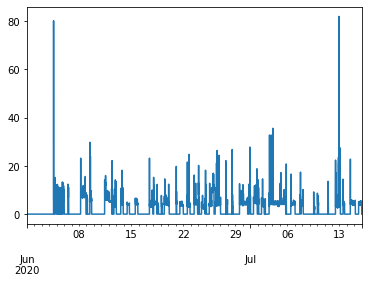

In [5]:
_ = df.CPU.plot()

In [6]:
train_size = round(len(df) * 0.75)

In [7]:
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
print("Number of training samples",len(train))
print("Number of testing samples",len(test))

Number of training samples 9721
Number of testing samples 3240



The Random walk model is :
X{t+1} = X{t}

so our prediction for at each time step, is the value in the previous time step

In [8]:
predicted = df.iloc[train_size-1:-1,:].CPU.to_numpy()

In [9]:
#adding +1 to avoid division by zero errors
mape( test.CPU+1,predicted+1)

6.919918920463505

In [10]:
#adding +1 to avoid division by zero errors
smape( test.CPU+1,predicted+1)

4.7311792165375355

In [11]:
WAVELET = "haar"

signal = df.CPU.values
coeffs = pywt.wavedec(signal, WAVELET)

coeffs[1:] = (pywt.threshold(detail,
                             value=0.5 * np.std(detail), 
                             mode="soft" ) for detail in coeffs[1:])
reconstructed_signal = pywt.waverec(coeffs, WAVELET)

In [12]:
#reconstructed_signal.shape
wavelet_prediction = reconstructed_signal[train_size:-1]

In [13]:
mape( test.CPU+1,wavelet_prediction+1)

55.174027637551106

In [14]:
smape( test.CPU+1,wavelet_prediction+1)

40.68701832858729

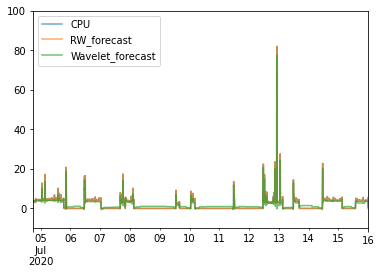

In [23]:
forecast = pd.Series([None for _ in range(len(train))])
forecast = forecast.append(pd.Series(predicted))
forecast.index = df.index

wavelet_forecast = pd.Series([None for _ in range(len(train))])
wavelet_forecast = wavelet_forecast.append(pd.Series(wavelet_prediction))
wavelet_forecast.index = df.index

final = pd.DataFrame(df.CPU)
final['RW_forecast'] = forecast
final['Wavelet_forecast'] = wavelet_forecast

axes = final.iloc[train_size:,0:3].plot(alpha = 0.65)
a = axes.set_ylim(-10,100)